In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
!pip install hdf5storage opencv-python albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 523.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.0 MB/s eta 0:00:00


In [ ]:
import os
import hdf5storage
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from tqdm import tqdm
import cv2
import shutil
import glob
import random
from PIL import Image

from google.colab import files, drive
# drive.mount('/content/drive')

# Imports for model development
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, utils, datasets
import copy

import torchvision
from torchvision.models import resnet18, ResNet18_Weights, vgg16, vgg19, VGG16_Weights, VGG19_Weights, vit_b_16, ViT_B_16_Weights, convnext_small, ConvNeXt_Small_Weights


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

import time

import warnings
warnings.filterwarnings("ignore")

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#Create directory
!mkdir -p brain_tumor_dataset
%cd brain_tumor_dataset

#Download dataset
!wget https://ndownloader.figshare.com/articles/1512427/versions/5 -O part.zip

#Unzip file and move mat files to data folder
!unzip part.zip && rm part.zip
!cat brainTumorDataPublic_* > brainTumorDataPublic_temp.zip
!zip -FF brainTumorDataPublic_temp.zip --out data.zip
!rm brainTumorDataPublic_*
!unzip data.zip -d data && rm data.zip

In [ ]:
# Set label map
labels_map = {0: "Meningioma", 1: "Glioma", 2: "Pituitary"}
labels_map

{0: 'Meningioma', 1: 'Glioma', 2: 'Pituitary'}

In [ ]:
# Lists to store data
records = []
mask_shape = []
# Read and parse all files
mat_files = [f for f in os.listdir('/content/brain_tumor_dataset/data') if f.endswith('.mat')]

for file in mat_files:
    path = os.path.join('/content/brain_tumor_dataset/data', file)
    data = hdf5storage.loadmat(path)['cjdata']

    label = int(np.squeeze(data['label'])) - 1
    tumor_mask = np.squeeze(data['tumorMask'])
    mask_shape.append(tumor_mask.shape)
    pid = str(np.squeeze(data['PID']))  # patient ID
    tumor_area = int(np.sum(tumor_mask))

    records.append({
        'file_name': file,
        'label': label,
        'label_name': labels_map[label],
        'patient_id': pid,
        'tumor_area': tumor_area
    })

# Create DataFrame
df = pd.DataFrame(records)
df.head()

,file_name,label,label_name,patient_id,tumor_area
0,1441.mat,2,Pituitary,98992,823
1,2607.mat,1,Glioma,MR051644C,9665
2,1249.mat,2,Pituitary,112074,2841
3,2368.mat,1,Glioma,MR040240C,16155
4,2466.mat,1,Glioma,MR029209G,3923


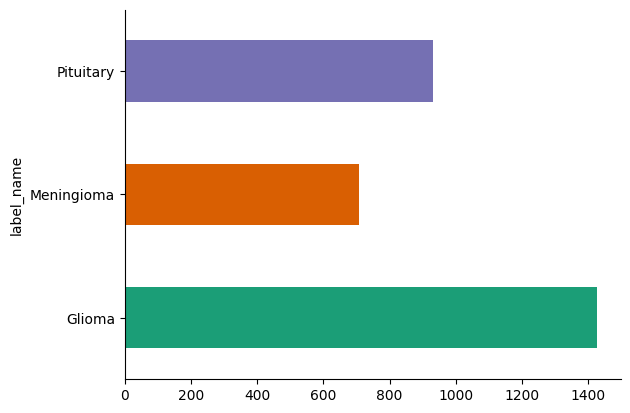

In [ ]:
# @title label_name

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.shape

(3064, 5)

Samples for class: Meningioma


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

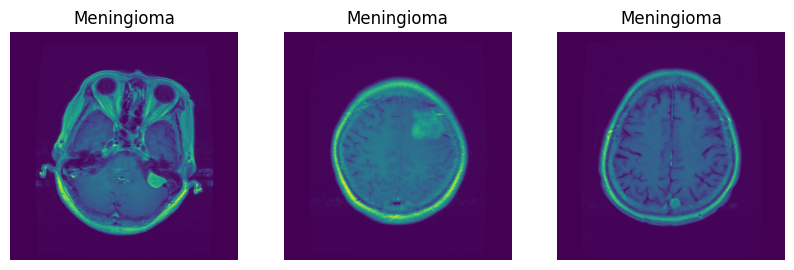

Samples for class: Glioma


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

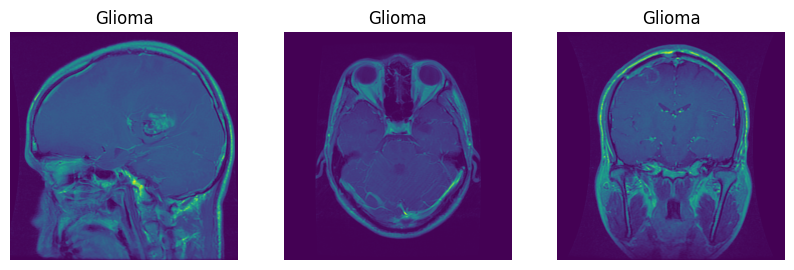

Samples for class: Pituitary


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

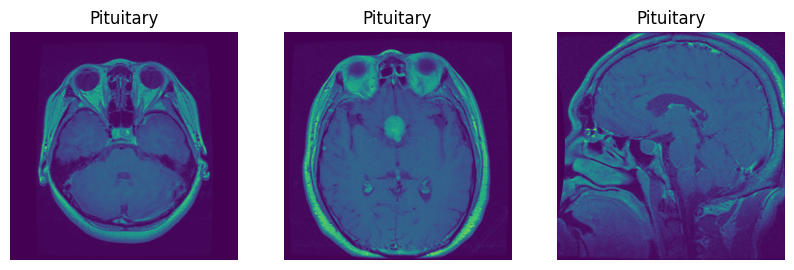

In [ ]:
# Function to plot sample images
def plot_sample_images(df, data_path, num_samples_per_class=3):
    for label, label_name in labels_map.items():
        print(f"Samples for class: {label_name}")
        class_df = df[df['label'] == label].sample(min(num_samples_per_class, len(df[df['label'] == label])), random_state=42)

        plt.figure(figsize=(10, 3))
        for i, row in enumerate(class_df.iterrows()):
            file_name = row[1]['file_name']
            path = os.path.join(data_path, file_name)
            data = hdf5storage.loadmat(path)['cjdata']
            image = np.squeeze(data['image'])

            pil_image = Image.fromarray(image).convert('L')
            image_filename = f'{label_name}_{i}.jpg'
            pil_image.save(image_filename)

            # Download to local machine
            # files.download(image_filename)


            plt.subplot(1, num_samples_per_class, i + 1)
            plt.imshow(image) #cmap='gray'
            plt.title(label_name)
            plt.axis('off')
        plt.show()

# Generate sample plots
plot_sample_images(df, '/content/brain_tumor_dataset/data')

In [ ]:
def balance_dataset(df, data_path, output_base_dir, target_per_class=650):
    """Balances the dataset by sampling a target number of images per class."""
    if os.path.exists(output_base_dir):
      shutil.rmtree(output_base_dir)
    os.makedirs(output_base_dir, exist_ok=True)

    balanced_files = []
    for label, label_name in labels_map.items():
        class_df = df[df['label'] == label]
        if len(class_df) > target_per_class:
            # Include 'patient_id' when sampling
            sampled_files_df = class_df.sample(target_per_class, random_state=42)[['file_name', 'label', 'label_name', 'patient_id']]
        else:
            # Include 'patient_id' for all files if not enough to sample
            sampled_files_df = class_df[['file_name', 'label', 'label_name', 'patient_id']]


        # Create directory for the class if it doesn't exist
        class_output_dir = os.path.join(output_base_dir, label_name)
        os.makedirs(class_output_dir, exist_ok=True)

        for index, row in sampled_files_df.iterrows():
            file_name = row['file_name']
            src_path = os.path.join(data_path, file_name)
            dest_path = os.path.join(class_output_dir, file_name)
            shutil.copy(src_path, dest_path)
            # Append the row (including patient_id) to balanced_files
            balanced_files.append(row.to_dict())


    balanced_df = pd.DataFrame(balanced_files)
    print(f"Balanced dataset created at {output_base_dir}")
    print("Class distribution in balanced dataset:")
    print(balanced_df['label_name'].value_counts())
    return balanced_df

# Define the output directory for the balanced dataset
balanced_output_dir = '/content/brain_tumor_dataset/balanced_data'

#Get the min class count
min_class_count = np.min(df['label_name'].value_counts())
# Balance the dataset
balanced_df = balance_dataset(df, '/content/brain_tumor_dataset/data', balanced_output_dir, min_class_count)

# You can now use balanced_df and the files in balanced_output_dir for further processing

Balanced dataset created at /content/brain_tumor_dataset/balanced_data
Class distribution in balanced dataset:
label_name
Meningioma    708
Glioma        708
Pituitary     708
Name: count, dtype: int64


In [ ]:
balanced_df.head()

,file_name,label,label_name,patient_id
0,691.mat,0,Meningioma,99089
1,557.mat,0,Meningioma,107494
2,3064.mat,0,Meningioma,88510
3,651.mat,0,Meningioma,114359
4,104.mat,0,Meningioma,108514


In [ ]:
# Split balanced data into training, validation, and testing sets
train_val_df, test_df = train_test_split(balanced_df, test_size=0.15, random_state=42, stratify=balanced_df['label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.15/0.85, random_state=42, stratify=train_val_df['label']) # 0.15 / 0.85 to get 15% of original data

# Create directories for the split datasets
base_split_dir = '/content/brain_tumor_dataset/data_split'
for split_name in ['train', 'val', 'test']:
    split_dir = os.path.join(base_split_dir, split_name)
    shutil.rmtree(split_dir, ignore_errors=True) # Remove if exists
    os.makedirs(split_dir, exist_ok=True)

# Function to copy files to split directories
def copy_split_files(split_df, split_name, data_path=balanced_output_dir):
    split_dir = os.path.join(base_split_dir, split_name)
    print(f"Copying files for {split_name} split...")
    for index, row in tqdm(split_df.iterrows(), total=len(split_df)):
        file_name = row['file_name']
        label_name = row['label_name']
        src_path = os.path.join(data_path, label_name, file_name) # Source is from balanced data
        dest_class_dir = os.path.join(split_dir, label_name)
        os.makedirs(dest_class_dir, exist_ok=True) # Create class directory within split
        dest_path = os.path.join(dest_class_dir, file_name)
        shutil.copy(src_path, dest_path)

# Copy files for each split
copy_split_files(train_df, 'train')
copy_split_files(val_df, 'val')
copy_split_files(test_df, 'test')

print("\nDataset split into train, validation, and test sets.")
print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

# Verify class distribution in each split
print("\nClass distribution in Train set:")
print(train_df['label_name'].value_counts())

print("\nClass distribution in Validation set:")
print(val_df['label_name'].value_counts())

print("\nClass distribution in Test set:")
print(test_df['label_name'].value_counts())


Copying files for train split...


100%|██████████| 1486/1486 [00:00<00:00, 2243.18it/s]


Copying files for val split...


100%|██████████| 319/319 [00:00<00:00, 2182.55it/s]


Copying files for test split...


100%|██████████| 319/319 [00:00<00:00, 2024.03it/s]


Dataset split into train, validation, and test sets.
Train set size: 1486
Validation set size: 319
Test set size: 319

Class distribution in Train set:
label_name
Glioma        496
Pituitary     495
Meningioma    495
Name: count, dtype: int64

Class distribution in Validation set:
label_name
Meningioma    107
Glioma        106
Pituitary     106
Name: count, dtype: int64

Class distribution in Test set:
label_name
Pituitary     107
Meningioma    106
Glioma        106
Name: count, dtype: int64


## Define Transformers

Define transformations for training and validation/testing

In [ ]:
# Augmentations for training set
train_transform = A.Compose([
    A.Affine(rotate=(-10, 10), translate_percent=(0.05, 0.05)),
    A.GaussianBlur(blur_limit=(3, 5)),
    A.HorizontalFlip(p=0.5),          # Random horizontal flip
    A.VerticalFlip(p=0.5),            # Random vertical flip
    A.RandomRotate90(p=0.5),          # Random 90 degree rotation
    A.Transpose(p=0.5),               # Transpose (flip and rotate)
    A.Resize(width=224, height=224),  # Resize images
    A.RandomBrightnessContrast(p=0.2),# Random brightness and contrast
    A.Normalize(mean=[0.485], std=[0.229]), # Normalize
    ToTensorV2(),                     # Convert numpy array to PyTorch tensor
])

# No augmentation for validation and test sets, only resize and normalize
val_test_transform = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=[0.485], std=[0.229]), # Normalize
    ToTensorV2(),
])


Create custom Dataset class

In [ ]:

class BrainTumorDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.labels_map = {0: "Meningioma", 1: "Glioma", 2: "Pituitary"}
        self.label_to_int = {name: label for label, name in self.labels_map.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_name = row['file_name']
        label_name = row['label_name']
        label = self.label_to_int[label_name]

        # The file is now located within the split directory and its class subdirectory
        file_path = os.path.join(self.data_dir, label_name, file_name)

        # Load the image data from the .mat file
        try:
            data = hdf5storage.loadmat(file_path)['cjdata']
            image = np.squeeze(data['image'])
            # Ensure the image is 3 channels if needed by the model, though for grayscale, 1 channel is fine
            # if you are using a model pre-trained on ImageNet, you might need to convert to 3 channels
            # For ResNet18_Weights.IMAGENET1K_V1, the input is expected to be 3 channels
            if image.ndim == 2:
                image = np.stack([image]*3, axis=-1) # Convert to 3 channels
            image = image.astype(np.float32) # Convert to float32 for Albumentations

        except Exception as e:
            print(f"Error loading or processing file {file_path}: {e}")
            # Return None or handle error appropriately, e.g., skip this item
            return None

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
             # If no transform, still resize and convert to tensor
             image = cv2.resize(image, (224, 224))
             if image.ndim == 2:
                 image = np.stack([image]*3, axis=-1)
             image = np.transpose(image, (2, 0, 1)) # Convert HWC to CHW
             image = torch.from_numpy(image).float()


        return image, label

# Create Dataset instances
train_dataset = BrainTumorDataset(train_df, os.path.join(base_split_dir, 'train'), transform=train_transform)
val_dataset = BrainTumorDataset(val_df, os.path.join(base_split_dir, 'val'), transform=val_test_transform)
test_dataset = BrainTumorDataset(test_df, os.path.join(base_split_dir, 'test'), transform=val_test_transform)

# Define DataLoader parameters
BATCH_SIZE = 32
NUM_WORKERS = 2

# Calculate weights for weighted random sampling for the training set
# This helps to handle any remaining slight class imbalance in the training set
class_counts = train_df['label'].value_counts().sort_index()
class_weights = 1. / class_counts
weights = class_weights[train_df['label']].values
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True # Drop the last batch if it's smaller than BATCH_SIZE
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle test data
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")



Number of batches in train_loader: 46
Number of batches in val_loader: 10
Number of batches in test_loader: 10


##Training on Resnet50 model

In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pre-trained ResNet50 model
# We use ResNet50_Weights.IMAGENET1K_V1 which expects 3-channel input
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

# Modify the classifier head to match the number of classes in our dataset
# The number of output features in the original classifier is model.fc.in_features
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(labels_map)) # Replace the last layer

# Move the model to the chosen device
model = model.to(device)

print("ResNet50 model defined and moved to device.")
# model

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 36.2MB/s]


ResNet50 model defined and moved to device.


In [ ]:
criterion = nn.CrossEntropyLoss()

# Setting optimizer for ResNet model
resnet_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device):
  model.train()  # Set model to training mode
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0

  for inputs, labels in tqdm(train_loader, desc="Training"):
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs.data, 1)
    total_samples += labels.size(0)
    correct_predictions += (predicted == labels).sum().item()

  epoch_loss = running_loss / total_samples
  epoch_acc = correct_predictions / total_samples
  return epoch_loss, epoch_acc

# Validation function
def validate_model(model, val_loader, criterion, device):
  model.eval()  # Set model to evaluation mode
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0

  with torch.no_grad():  # Disable gradient calculation during validation
    for inputs, labels in tqdm(val_loader, desc="Validation"):
      inputs, labels = inputs.to(device), labels.to(device)

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs.data, 1)
      total_samples += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

  epoch_loss = running_loss / total_samples
  epoch_acc = correct_predictions / total_samples
  return epoch_loss, epoch_acc

In [ ]:
# Training loop
num_epochs = 20
patience = 4

epoch_no_improve = 0
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


print("Starting training on Resnet50 model with early stopping")
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}/{num_epochs}:")
  train_loss, train_acc = train_model(model, train_loader, criterion, resnet_optimizer, device)
  val_loss, val_acc = validate_model(model, val_loader, criterion, device)

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)


  print("\nChecking epoch performance")
  print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
  print(f"  Val Loss: {val_loss:.4f},   Val Acc: {val_acc:.4f}")


  # Early stopping
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    epoch_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    print("Best Model updated")
  else:
    epoch_no_improve += 1
    if epoch_no_improve >= patience:
      print(f"\n Early stopping triggered after {epoch+1} epochs.")
      break


print("Training finished.")

# Load the best model
best_model_wts = copy.deepcopy(model.state_dict())
print(f"Best model accuracy: {best_val_acc:.4f}")

Starting training on Resnet50 model with early stopping
Epoch 1/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]



Checking epoch performance
  Train Loss: 0.9706, Train Acc: 0.4620
  Val Loss: 0.5945,   Val Acc: 0.7900
Best Model updated
Epoch 2/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.72it/s]



Checking epoch performance
  Train Loss: 0.9138, Train Acc: 0.5061
  Val Loss: 0.3700,   Val Acc: 0.8433
Best Model updated
Epoch 3/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]



Checking epoch performance
  Train Loss: 0.8577, Train Acc: 0.5211
  Val Loss: 0.2817,   Val Acc: 0.8966
Best Model updated
Epoch 4/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.96it/s]



Checking epoch performance
  Train Loss: 0.8219, Train Acc: 0.5272
  Val Loss: 0.4790,   Val Acc: 0.8777
Epoch 5/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.63it/s]



Checking epoch performance
  Train Loss: 0.8355, Train Acc: 0.5292
  Val Loss: 0.4332,   Val Acc: 0.8746
Epoch 6/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s]



Checking epoch performance
  Train Loss: 0.8069, Train Acc: 0.5340
  Val Loss: 0.2484,   Val Acc: 0.8903
Epoch 7/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]



Checking epoch performance
  Train Loss: 0.7930, Train Acc: 0.5476
  Val Loss: 0.2672,   Val Acc: 0.9028
Best Model updated
Epoch 8/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.63it/s]



Checking epoch performance
  Train Loss: 0.7705, Train Acc: 0.5462
  Val Loss: 0.1634,   Val Acc: 0.9373
Best Model updated
Epoch 9/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]



Checking epoch performance
  Train Loss: 0.7697, Train Acc: 0.5652
  Val Loss: 0.1778,   Val Acc: 0.9342
Epoch 10/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.72it/s]



Checking epoch performance
  Train Loss: 0.7862, Train Acc: 0.5537
  Val Loss: 0.2444,   Val Acc: 0.9091
Epoch 11/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]



Checking epoch performance
  Train Loss: 0.7777, Train Acc: 0.5510
  Val Loss: 0.2176,   Val Acc: 0.9404
Best Model updated
Epoch 12/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.68it/s]



Checking epoch performance
  Train Loss: 0.7714, Train Acc: 0.5564
  Val Loss: 0.1487,   Val Acc: 0.9279
Epoch 13/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]



Checking epoch performance
  Train Loss: 0.7555, Train Acc: 0.5625
  Val Loss: 0.1724,   Val Acc: 0.9467
Best Model updated
Epoch 14/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]



Checking epoch performance
  Train Loss: 0.7647, Train Acc: 0.5489
  Val Loss: 0.1493,   Val Acc: 0.9404
Epoch 15/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]



Checking epoch performance
  Train Loss: 0.7568, Train Acc: 0.5476
  Val Loss: 0.1409,   Val Acc: 0.9530
Best Model updated
Epoch 16/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s]



Checking epoch performance
  Train Loss: 0.7434, Train Acc: 0.5611
  Val Loss: 0.2860,   Val Acc: 0.9028
Epoch 17/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]



Checking epoch performance
  Train Loss: 0.7454, Train Acc: 0.5693
  Val Loss: 0.1619,   Val Acc: 0.9436
Epoch 18/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s]



Checking epoch performance
  Train Loss: 0.7473, Train Acc: 0.5584
  Val Loss: 0.1563,   Val Acc: 0.9404
Epoch 19/20:


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


Checking epoch performance
  Train Loss: 0.7748, Train Acc: 0.5469
  Val Loss: 0.2075,   Val Acc: 0.9154

 Early stopping triggered after 19 epochs.
Training finished.
Best model accuracy: 0.9530


In [ ]:
# plt.figure(figsize=(8, 6))

# plt.plot(train_accuracies, label='Training Accuracies', color='blue')
# plt.plot(val_accuracies, label='Validation Accuracies', color='orange')

# # Vertical line where validation loss is minimum (early stopping hint)
# max_val_loss_epoch = val_accuracies.index(max(val_accuracies))
# plt.axvline(max_val_loss_epoch, color='gray', linestyle='--', label=f'Suggested Stop (Epoch {max_val_loss_epoch})')

# plt.title('Training vs Validation Accuracy Plot')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracies')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

## Criss cross graph on training and validation loss

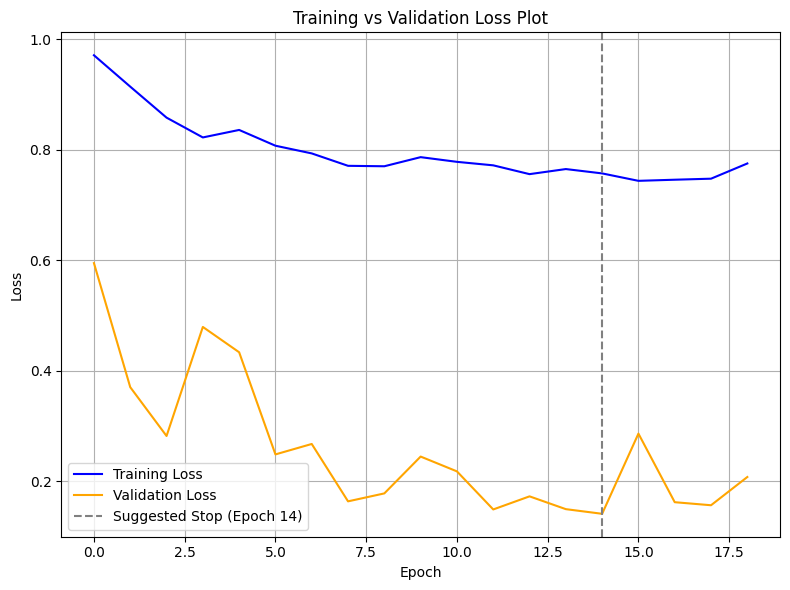

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')

# Vertical line where validation loss is minimum (early stopping hint)
min_val_loss_epoch = val_losses.index(min(val_losses))
plt.axvline(min_val_loss_epoch, color='gray', linestyle='--', label=f'Suggested Stop (Epoch {min_val_loss_epoch})')


plt.title('Training vs Validation Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This plot shows how the model learns over time.

Training loss decreases as the model fits the data.

Validation loss initially drops, then starts to rise — indicating overfitting.

The point where they cross is the ideal stopping point, where the model performs best on unseen data.

Classifying Test Set: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]



Inference time per batch: 0.2258 seconds

Classification Report:
              precision    recall  f1-score   support

  Meningioma       0.99      0.78      0.87       106
      Glioma       0.94      0.95      0.94       106
   Pituitary       0.84      1.00      0.91       107

    accuracy                           0.91       319
   macro avg       0.92      0.91      0.91       319
weighted avg       0.92      0.91      0.91       319


Confusion Matrix:
[[ 83   7  16]
 [  1 101   4]
 [  0   0 107]]


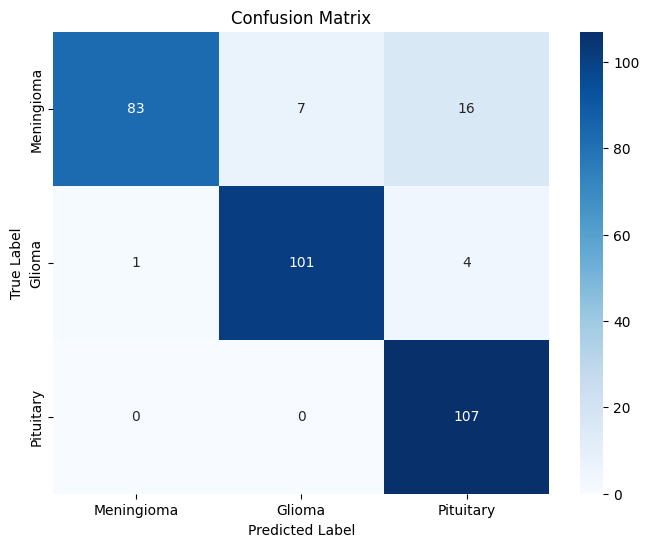


Overall Accuracy on Test Set: 0.9122


In [ ]:
# Classification function for the test set
def classify_test_set(model, test_loader, device):
  model.eval() # Set model to evaluation mode
  all_predictions = []
  all_labels = []

  start_time = time.time()
  with torch.no_grad(): # Disable gradient calculation
    for inputs, labels in tqdm(test_loader, desc="Classifying Test Set"):
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)

      all_predictions.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  # Calculate inference time
  end_time = time.time()
  inference_time = end_time - start_time
  avg_inference_time = inference_time/len(test_loader)

  return all_predictions, all_labels, avg_inference_time

# Classify the test set
test_predictions, test_labels, resnet_inf_time = classify_test_set(model, test_loader, device)

# Get the list of class names
class_names = list(labels_map.values())

# Show inference time
print(f"\nInference time per batch: {resnet_inf_time:.4f} seconds")

# Generate Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(test_labels, test_predictions)
print(f"\nOverall Accuracy on Test Set: {overall_accuracy:.4f}")


## Training on VGG Model

In [ ]:
# Choose one
use_vgg16 = True  # Set to False to use VGG19 instead

if use_vgg16:
  version = 16
  weights = VGG16_Weights.DEFAULT
  vgg_model = vgg16(weights=weights)
else:
  version = 19
  weights = VGG19_Weights.DEFAULT
  vgg_model = vgg19(weights=weights)

# Replace the classifier to match our number of classes
num_classes = len(labels_map)
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, num_classes)

vgg_model = vgg_model.to(device)

# Define the optimizer
vgg_optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.0001)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:15<00:00, 34.9MB/s]


Starting training with early stopping on VGG 16 model...


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


Epoch 1/20:
  Train Loss: 1.0610, Train Acc: 0.4395
  Val Loss: 0.7267,   Val Acc: 0.5862
Best Model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Epoch 2/20:
  Train Loss: 0.9207, Train Acc: 0.4871
  Val Loss: 0.5813,   Val Acc: 0.8025
Best Model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


Epoch 3/20:
  Train Loss: 0.9013, Train Acc: 0.4993
  Val Loss: 0.7361,   Val Acc: 0.6144


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


Epoch 4/20:
  Train Loss: 0.8580, Train Acc: 0.5231
  Val Loss: 0.3634,   Val Acc: 0.8683
Best Model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


Epoch 5/20:
  Train Loss: 0.8375, Train Acc: 0.5360
  Val Loss: 0.4099,   Val Acc: 0.7868


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


Epoch 6/20:
  Train Loss: 0.9342, Train Acc: 0.5014
  Val Loss: 0.4914,   Val Acc: 0.8339


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


Epoch 7/20:
  Train Loss: 0.8719, Train Acc: 0.5442
  Val Loss: 0.9586,   Val Acc: 0.7649


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


Epoch 8/20:
  Train Loss: 0.8542, Train Acc: 0.5353
  Val Loss: 0.3003,   Val Acc: 0.8683
Early stopping triggered after 8 epochs.
Training finished.
Training complete. Best validation accuracy 0.8683


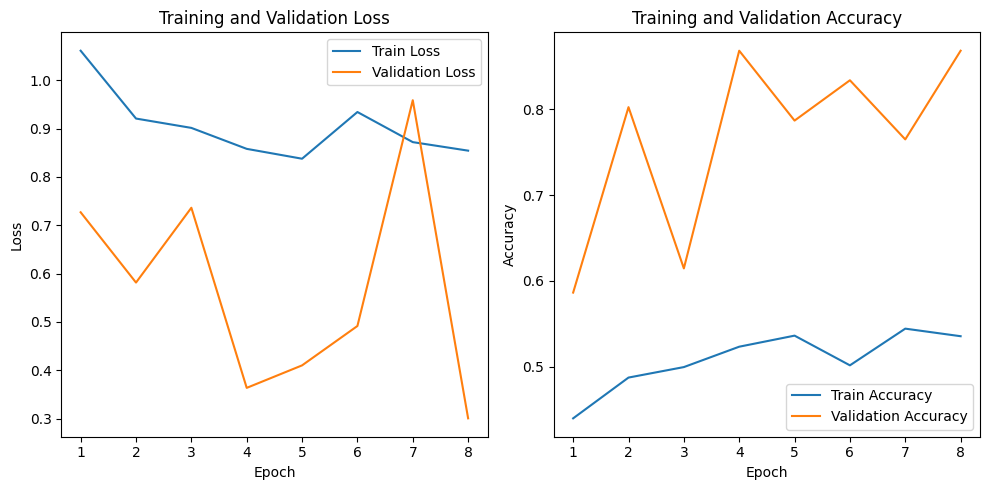

In [ ]:
# Training loop
num_epochs = 20
patience = 4


train_losses, train_accuracies= [], []
val_losses, val_accuracies = [], []


best_val_acc = 0.0
epoch_no_improve = 0
best_model_wts = copy.deepcopy(vgg_model.state_dict())

torch.cuda.empty_cache()

print(f"Starting training with early stopping on VGG {version} model...")
for epoch in range(num_epochs):
  train_loss, train_acc = train_model(vgg_model, train_loader, criterion, vgg_optimizer, device)
  val_loss, val_acc = validate_model(vgg_model, val_loader, criterion, device)

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)


  print(f"Epoch {epoch+1}/{num_epochs}:")
  print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
  print(f"  Val Loss: {val_loss:.4f},   Val Acc: {val_acc:.4f}")

  # Early stopping
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    epoch_no_improve = 0
    best_model_wts = copy.deepcopy(vgg_model.state_dict())
    print("Best Model updated")
  else:
    epoch_no_improve += 1
    if epoch_no_improve >= patience:
      print(f"Early stopping triggered after {epoch+1} epochs.")
      break
print("Training finished.")

vgg_model.load_state_dict(best_model_wts)
print(f"Training complete. Best validation accuracy {best_val_acc:.4f}")

#Plot training and validation metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Criss cross Graph on training and validaiton losses

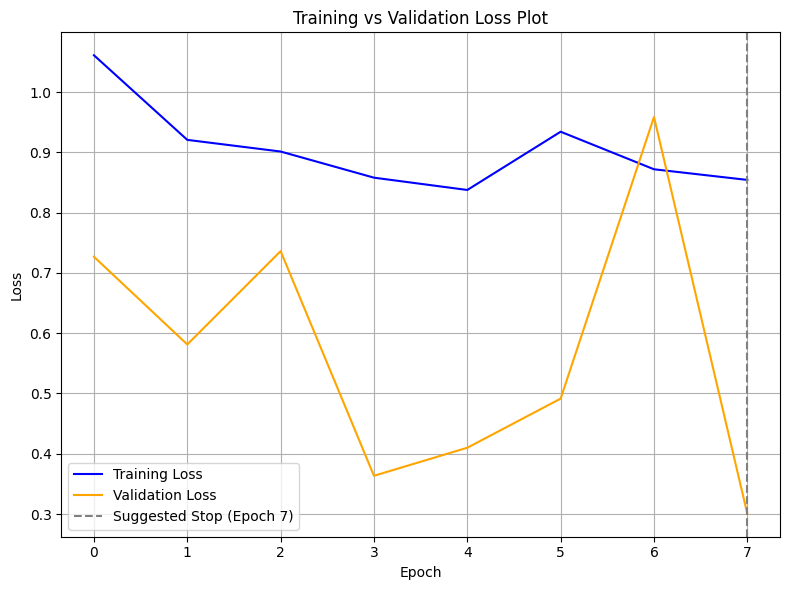

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')

# Vertical line where validation loss is minimum (early stopping hint)
min_val_loss_epoch = val_losses.index(min(val_losses))
plt.axvline(min_val_loss_epoch, color='gray', linestyle='--', label=f'Suggested Stop (Epoch {min_val_loss_epoch})')


plt.title('Training vs Validation Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Classifying Test Set: 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]



Overall Accuracy on Test Set: 0.8370

Average Inference time: 0.2374 seconds

Classification Report:
              precision    recall  f1-score   support

  Meningioma       0.71      0.95      0.81       106
      Glioma       0.90      0.77      0.83       106
   Pituitary       0.98      0.79      0.87       107

    accuracy                           0.84       319
   macro avg       0.86      0.84      0.84       319
weighted avg       0.86      0.84      0.84       319


Confusion Matrix:
[[101   4   1]
 [ 23  82   1]
 [ 18   5  84]]


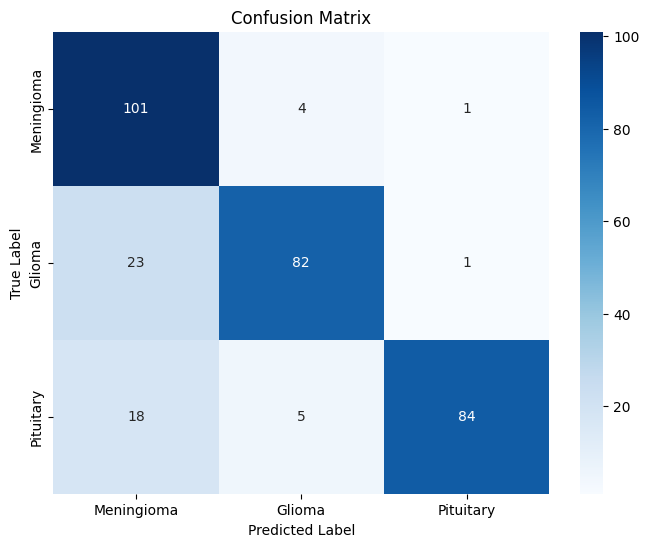

In [ ]:
# Classification function for the test set
def classify_test_set(model, test_loader, device):
  vgg_model.eval() # Set model to evaluation mode
  all_predictions = []
  all_labels = []

  start_time = time.time()
  with torch.no_grad(): # Disable gradient calculation
    for inputs, labels in tqdm(test_loader, desc="Classifying Test Set"):
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = vgg_model(inputs)
      _, predicted = torch.max(outputs.data, 1)

      all_predictions.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
  end_time = time.time()
  inference_time = end_time - start_time
  avg_inference_time = inference_time/len(test_loader)

  return all_predictions, all_labels, avg_inference_time

# Classify the test set
test_predictions, test_labels, avg_vgg_inf_time = classify_test_set(vgg_model, test_loader, device)

# Get the list of class names
class_names = list(labels_map.values())

# Calculate overall accuracy
overall_accuracy = accuracy_score(test_labels, test_predictions)
print(f"\nOverall Accuracy on Test Set: {overall_accuracy:.4f}")

print(f"\nAverage Inference time: {avg_vgg_inf_time:.4f} seconds")

# Generate Classification Report
print("\nClassification Report:")

print(classification_report(test_labels, test_predictions, target_names=class_names))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Vit Model

In [ ]:
# from torchvision.models import ViT_B_16_Weights

vit_model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, 3)
vit_model = vit_model.to(device)

vit_optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.0001)

In [ ]:
# Training config
num_epochs = 20
patience = 4

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_val_acc = 0.0
epoch_no_improve = 0
best_model_wts = copy.deepcopy(vit_model.state_dict())

print("Starting ViT training...")

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(vit_model, train_loader, criterion, vit_optimizer, device)
    val_loss, val_acc = validate_model(vit_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epoch_no_improve = 0
        best_model_wts = copy.deepcopy(vit_model.state_dict())
        print("  🔼 Best model updated")
    else:
        epoch_no_improve += 1
        if epoch_no_improve >= patience:
            print("⏹️ Early stopping triggered.")
            break

# Load best model
vit_model.load_state_dict(best_model_wts)
print(f"✅ Training done. Best val accuracy: {best_val_acc:.4f}")


Starting ViT training...


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch 1/20
  Train Loss: 1.0882, Acc: 0.4110
  Val   Loss: 0.9672, Acc: 0.4702
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


Epoch 2/20
  Train Loss: 0.9887, Acc: 0.4531
  Val   Loss: 0.6502, Acc: 0.7241
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


Epoch 3/20
  Train Loss: 0.9493, Acc: 0.4878
  Val   Loss: 0.6663, Acc: 0.6803


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch 4/20
  Train Loss: 0.9253, Acc: 0.4918
  Val   Loss: 0.5258, Acc: 0.8213
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch 5/20
  Train Loss: 0.9308, Acc: 0.4864
  Val   Loss: 0.6051, Acc: 0.7900


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


Epoch 6/20
  Train Loss: 0.9200, Acc: 0.4830
  Val   Loss: 0.6486, Acc: 0.7147


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch 7/20
  Train Loss: 0.9218, Acc: 0.4803
  Val   Loss: 0.4661, Acc: 0.8307
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Epoch 8/20
  Train Loss: 0.8794, Acc: 0.5054
  Val   Loss: 0.4728, Acc: 0.8245


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch 9/20
  Train Loss: 0.8629, Acc: 0.5163
  Val   Loss: 0.4117, Acc: 0.8621
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch 10/20
  Train Loss: 0.8778, Acc: 0.5129
  Val   Loss: 0.5222, Acc: 0.7743


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch 11/20
  Train Loss: 0.8277, Acc: 0.5258
  Val   Loss: 0.3743, Acc: 0.8589


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


Epoch 12/20
  Train Loss: 0.8572, Acc: 0.5211
  Val   Loss: 0.3835, Acc: 0.8307


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch 13/20
  Train Loss: 0.8336, Acc: 0.5326
  Val   Loss: 0.3485, Acc: 0.8683
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch 14/20
  Train Loss: 0.8737, Acc: 0.5109
  Val   Loss: 0.5086, Acc: 0.7712


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch 15/20
  Train Loss: 0.8839, Acc: 0.5143
  Val   Loss: 0.3702, Acc: 0.8495


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch 16/20
  Train Loss: 0.8609, Acc: 0.5136
  Val   Loss: 0.3687, Acc: 0.8495


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]

Epoch 17/20
  Train Loss: 0.8333, Acc: 0.5183
  Val   Loss: 0.4118, Acc: 0.8339
⏹️ Early stopping triggered.
✅ Training done. Best val accuracy: 0.8683


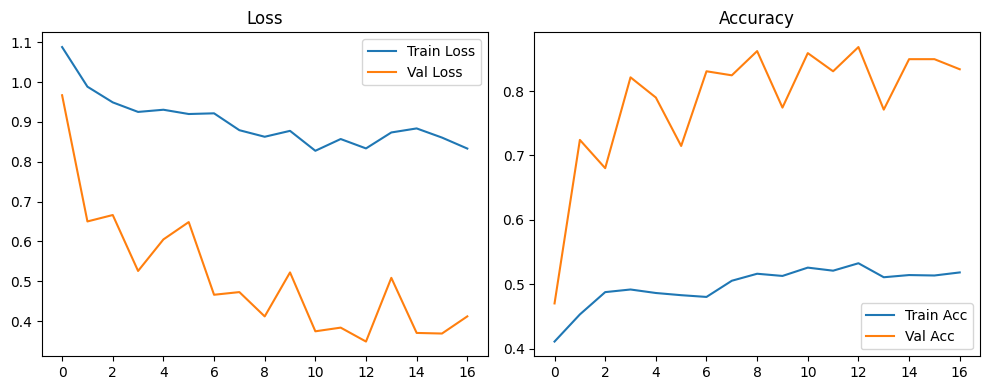

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Criss cross graph for training and validation loss

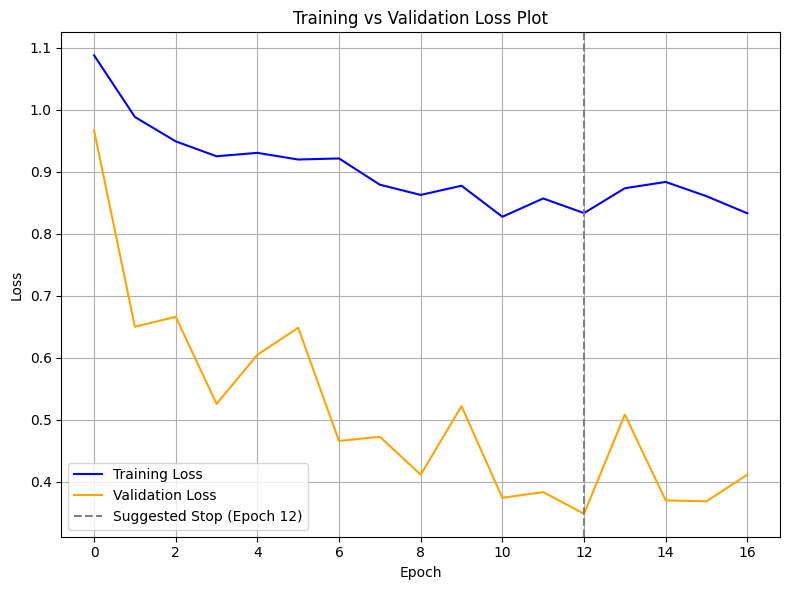

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')

# Vertical line where validation loss is minimum (early stopping hint)
min_val_loss_epoch = val_losses.index(min(val_losses))
plt.axvline(min_val_loss_epoch, color='gray', linestyle='--', label=f'Suggested Stop (Epoch {min_val_loss_epoch})')


plt.title('Training vs Validation Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluation on the test set

In [ ]:
vit_model.eval()

all_preds = []
all_labels = []

start_time = time.time()  # ⏱️ Start timing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vit_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

inference_time = time.time() - start_time
avg_inference_time = inference_time / len(test_loader.dataset)

# ✅ Test Accuracy
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)
test_accuracy = correct / total

print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print(f"⏱️ Total Inference Time: {inference_time:.4f} seconds")
print(f"⏱️ Average Time per Image: {avg_inference_time:.6f} seconds")

# 📊 Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(labels_map.values())))

# 📊 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)



✅ Test Accuracy: 0.8621
⏱️ Total Inference Time: 3.9256 seconds
⏱️ Average Time per Image: 0.012306 seconds

Classification Report:
              precision    recall  f1-score   support

  Meningioma       0.79      0.84      0.82       106
      Glioma       0.94      0.80      0.87       106
   Pituitary       0.86      0.94      0.90       107

    accuracy                           0.86       319
   macro avg       0.87      0.86      0.86       319
weighted avg       0.87      0.86      0.86       319



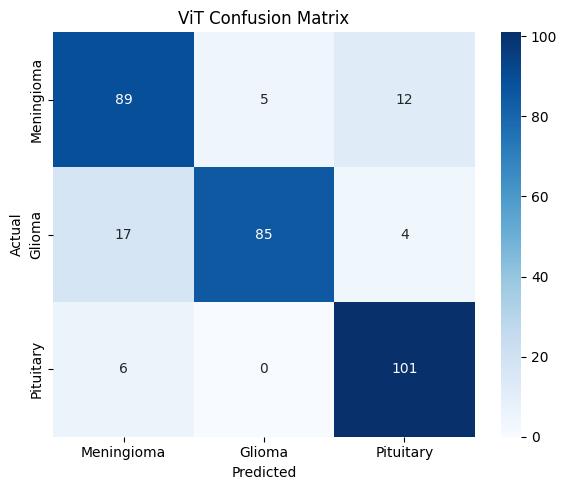

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(labels_map.values()),
            yticklabels=list(labels_map.values()))
plt.title('ViT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


## ConvNeXt Model

In [ ]:
convnext_model = convnext_small(weights=ConvNeXt_Small_Weights.DEFAULT)

convnext_model.classifier[2] = nn.Linear(convnext_model.classifier[2].in_features, 3) # Replace the classification head to match our number of classes

convnext_model = convnext_model.to(device)

convnext_parameters = convnext_model.parameters()

convnext_optimizer = torch.optim.Adam(convnext_parameters, lr=0.0001)

In [ ]:
# Training config
num_epochs = 20
patience = 4

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_val_acc = 0.0
epoch_no_improve = 0
best_model_wts = copy.deepcopy(convnext_model.state_dict())

print("Starting ConvNeXT training...")

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(convnext_model, train_loader, criterion, convnext_optimizer, device)
    val_loss, val_acc = validate_model(convnext_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epoch_no_improve = 0
        best_model_wts = copy.deepcopy(convnext_model.state_dict())
        print("  🔼 Best model updated")
    else:
        epoch_no_improve += 1
        if epoch_no_improve >= patience:
            print("⏹️ Early stopping triggered.")
            break

# Load best model
convnext_model.load_state_dict(best_model_wts)
print(f"✅ Training done. Best val accuracy: {best_val_acc:.4f}")


Starting ConvNeXT training...


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch 1/20
  Train Loss: 0.9973, Acc: 0.4599
  Val   Loss: 0.4452, Acc: 0.8558
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch 2/20
  Train Loss: 0.8701, Acc: 0.5007
  Val   Loss: 0.3379, Acc: 0.8683
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch 3/20
  Train Loss: 0.8007, Acc: 0.5319
  Val   Loss: 0.1523, Acc: 0.9342
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch 4/20
  Train Loss: 0.7848, Acc: 0.5319
  Val   Loss: 0.2285, Acc: 0.9060


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch 5/20
  Train Loss: 0.7621, Acc: 0.5611
  Val   Loss: 0.1486, Acc: 0.9310


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch 6/20
  Train Loss: 0.7673, Acc: 0.5530
  Val   Loss: 0.1262, Acc: 0.9561
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch 7/20
  Train Loss: 0.7710, Acc: 0.5380
  Val   Loss: 0.1573, Acc: 0.9373


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch 8/20
  Train Loss: 0.7346, Acc: 0.5727
  Val   Loss: 0.1131, Acc: 0.9655
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch 9/20
  Train Loss: 0.7362, Acc: 0.5639
  Val   Loss: 0.0812, Acc: 0.9781
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch 10/20
  Train Loss: 0.7141, Acc: 0.5740
  Val   Loss: 0.0782, Acc: 0.9812
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 11/20
  Train Loss: 0.7120, Acc: 0.5747
  Val   Loss: 0.0885, Acc: 0.9781


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch 12/20
  Train Loss: 0.7203, Acc: 0.5686
  Val   Loss: 0.0929, Acc: 0.9749


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch 13/20
  Train Loss: 0.7255, Acc: 0.5754
  Val   Loss: 0.1003, Acc: 0.9561


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch 14/20
  Train Loss: 0.7408, Acc: 0.5686
  Val   Loss: 0.0676, Acc: 0.9843
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch 15/20
  Train Loss: 0.7344, Acc: 0.5523
  Val   Loss: 0.0802, Acc: 0.9749


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch 16/20
  Train Loss: 0.7213, Acc: 0.5618
  Val   Loss: 0.1166, Acc: 0.9530


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Epoch 17/20
  Train Loss: 0.7164, Acc: 0.5673
  Val   Loss: 0.0694, Acc: 0.9812


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch 18/20
  Train Loss: 0.7172, Acc: 0.5700
  Val   Loss: 0.0636, Acc: 0.9875
  🔼 Best model updated


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Epoch 19/20
  Train Loss: 0.7073, Acc: 0.5734
  Val   Loss: 0.0721, Acc: 0.9843


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

Epoch 20/20
  Train Loss: 0.7107, Acc: 0.5740
  Val   Loss: 0.0603, Acc: 0.9812
✅ Training done. Best val accuracy: 0.9875


### Criss Cross graph showing training and Validation losses on ConvNeXt Model

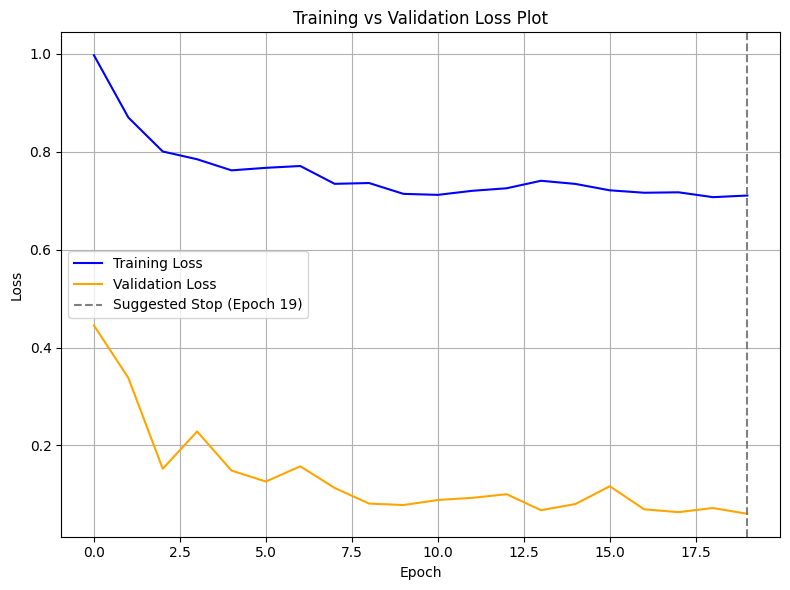

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')

# Vertical line where validation loss is minimum (early stopping hint)
min_val_loss_epoch = val_losses.index(min(val_losses))
plt.axvline(min_val_loss_epoch, color='gray', linestyle='--', label=f'Suggested Stop (Epoch {min_val_loss_epoch})')


plt.title('Training vs Validation Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


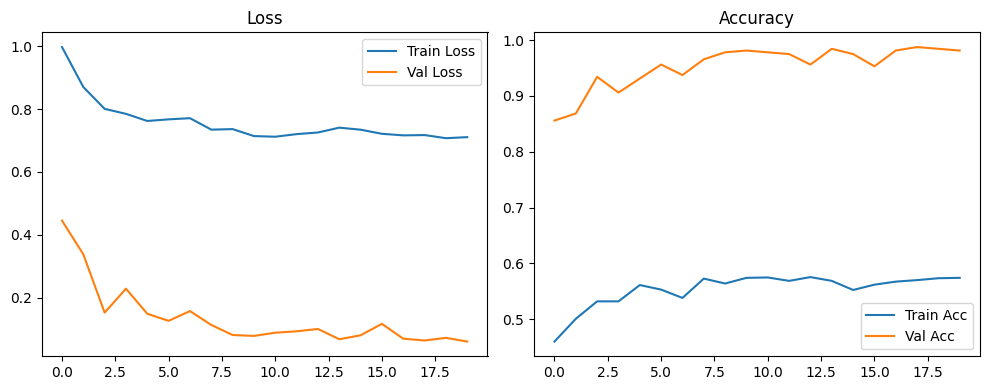

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation and Best Model Selection

In [ ]:
def evaluate_and_record(model, model_name, test_loader, device, labels_map):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=list(labels_map.values()), output_dict=True)

    # print(report)

    return {
        "Model": model_name,
        "Accuracy": round(acc, 4),
        "Macro F1": round(report["macro avg"]["f1-score"], 2),
        "Meningioma F1": round(report["Meningioma"]["f1-score"], 2),
        "Glioma F1": round(report["Glioma"]["f1-score"], 2),
        "Pituitary F1": round(report["Pituitary"]["f1-score"], 2),
        "Meningioma Recall": round(report["Meningioma"]["recall"], 2),
        "Glioma Recall": round(report["Glioma"]["recall"], 2),
        "Pituitary Recall": round(report["Pituitary"]["recall"], 2)
    }

# Evaluate each model and collect results
results = []
results.append(evaluate_and_record(vgg_model, "VGG", test_loader, device, labels_map))
results.append(evaluate_and_record(model, "ResNet", test_loader, device, labels_map))
results.append(evaluate_and_record(vit_model, "ViT", test_loader, device, labels_map))
results.append(evaluate_and_record(convnext_model, "ConvNeXt", test_loader, device, labels_map))
# Display as a styled DataFrame
df_results = pd.DataFrame(results).set_index("Model")

def highlight_max(s):
    return ['background-color: blue' if v == max(s) else '' for v in s]

df_results.style.apply(highlight_max, subset=["Accuracy", "Macro F1", "Meningioma F1", "Glioma F1", "Pituitary F1", "Meningioma Recall", "Glioma Recall", "Pituitary Recall"])


,Accuracy,Macro F1,Meningioma F1,Glioma F1,Pituitary F1,Meningioma Recall,Glioma Recall,Pituitary Recall
Model,,,,,,,,
VGG,0.837000,0.840000,0.810000,0.830000,0.870000,0.950000,0.770000,0.790000
ResNet,0.912200,0.910000,0.870000,0.940000,0.910000,0.780000,0.950000,1.000000
ViT,0.862100,0.860000,0.820000,0.870000,0.900000,0.840000,0.800000,0.940000
ConvNeXt,0.962400,0.960000,0.950000,0.970000,0.970000,0.930000,1.000000,0.950000


## Saving Model

In [ ]:
torch.save(model.state_dict(), "resnet_model.pth")
torch.save(vit_model.state_dict(), "vit_model.pth")
torch.save(vgg_model.state_dict(), "vgg_model.pth")
torch.save(convnext_model.state_dict(), "convnext_model.pth")

In [ ]:
from google.colab import files, drive

drive.mount('/content/drive')

torch.save(vgg_model.state_dict(), "/content/drive/MyDrive/vgg_model.pth")
torch.save(vit_model.state_dict(), "/content/drive/MyDrive/vit_model.pth")
torch.save(model.state_dict(), "/content/drive/MyDrive/resnet_model.pth")
torch.save(convnext_model.state_dict(), "/content/drive/MyDrive/convnext_model.pth")

# files.download("/content/drive/MyDrive/vgg_model.pth")


Mounted at /content/drive


In [ ]:
import sys, os
import torch
import pandas as pd
os.getcwd()

'/content/brain_tumor_dataset'

In [ ]:
# Testing the VGG Model
# from torchvision.models import vgg16, vgg16_weights
# from torch import nn

vgg_model_loaded = vgg16(weights=VGG16_Weights.DEFAULT)
vgg_model_loaded.classifier[6] = nn.Linear(vgg_model_loaded.classifier[6].in_features, 3)
vgg_model_loaded.load_state_dict(torch.load('../drive/MyDrive/Colab Models/vgg_model.pth', map_location=torch.device('cpu')))
vgg_model_loaded.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cpu')

In [ ]:
results = []
vgg_model_loaded = vgg_model_loaded.to(device)
with torch.no_grad(): # Disable gradient calculation
  for inputs, labels in tqdm(test_loader, desc="Classifying Test Set"):
    inputs, labels = inputs.to(device), labels.to(device)


    outputs = vgg_model_loaded(inputs)
    _, predicted = torch.max(outputs.data, 1)

    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    for label, prediction in zip(labels, predicted):
      results.append({"Label": label, "Prediction": prediction})

In [ ]:
result_df = pd.DataFrame(results)

print(result_df.shape)
result_df.head()

(319, 2)


,Label,Prediction
0,0,0
1,1,1
2,0,0
3,1,1
4,0,0


In [ ]:
result_df['Prediction'].value_counts()

,count
Prediction,
0,109
1,109
2,101


In [ ]:
result_df[result_df['Label'] != result_df['Prediction']]

,Label,Prediction
5,1,0
22,1,0
54,2,1
89,2,0
90,0,1
121,2,1
185,2,0
199,0,1
205,0,1
272,2,0


In [ ]:
import google.colab as colab
import google.colab.drive as drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Saving all Images from the Test Folder

In [ ]:

cwd = os.getcwd()
test_path = os.path.join(cwd, 'data_split', 'test')

drive_save_dir = '/content/drive/MyDrive/MRI_SCAN_IMAGES'
os.makedirs(drive_save_dir, exist_ok=True)

# Define label map
labels_map = {0: "Meningioma", 1: "Glioma", 2: "Pituitary"}


for label_folder in os.listdir(test_path):
    path = os.path.join(test_path, label_folder)
    print(path)

    for file in os.listdir(path):
        data = hdf5storage.loadmat(os.path.join(path, file))['cjdata']
        img_arr = np.squeeze(data['image']).astype(np.float32)

        # Normalize and convert to 8-bit
        img_norm = 255 * (img_arr - img_arr.min()) / (img_arr.max() - img_arr.min() + 1e-5)
        img_8bit = img_norm.astype(np.uint8)

        label = int(data['label'].item()) - 1
        pil_image = Image.fromarray(img_8bit, mode='L')  # 'L' = 8-bit grayscale

        file_name = f'{file.split(".")[0]}_{labels_map.get(label)}.png'
        print(f'saving {file_name}')
        save_path = os.path.join(drive_save_dir, file_name)
        pil_image.save(save_path)

    print(f"✅ Done saving images for: {label_folder}")

